In [2]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [6]:
if not (os.path.isfile('Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

#if not (os.path.isfile('/content/Salinas_corrected.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_corrected.mat
#if not (os.path.isfile('/content/Salinas_gt.mat')):
#  !wget https://github.com/gokriznastic/HybridSN/raw/master/data/Salinas_gt.mat

--2023-12-23 05:00:46--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2023-12-23 05:00:46--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.18MB/s    in 2.6s    

2023-12-23 05:00:49 (2.18 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-12-23 05:00:49--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

# Data Loading

In [3]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.7
windowSize = 25

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']

    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [11]:
X, y = loadData(dataset)

X.shape, y.shape

((610, 340, 103), (610, 340))

In [12]:
K = X.shape[2]

In [13]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(610, 340, 15)

In [11]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((42776, 25, 25, 15), (42776,))

In [12]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12832, 25, 25, 15), (29944, 25, 25, 15), (12832,), (29944,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [18]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(12832, 25, 25, 15, 1)

In [19]:
ytrain = keras.utils.to_categorical(ytrain)
ytrain.shape

(12832, 9)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [20]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [21]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [22]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [23]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25, 25, 15, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 23, 23, 9, 8)   │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 21, 21, 5, 16)  │         5,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 19, 19, 3, 32)  │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 17, 17, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,735,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,844,793 (18.48 MB)

 Trainable params: 4,844,793 (18.48 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [14]:
# compiling the model
#adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

NameError: name 'model' is not defined

In [ ]:
# checkpoint
filepath = "best-model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [23]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 318ms/step - accuracy: 0.4999 - loss: 1.5114
Epoch 2/100


c:\Users\Valentin\.pyenv\pyenv-win\versions\3.11.9\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:209: UserWarning:

Can save best model only with acc available, skipping.



51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.9228 - loss: 0.2214
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.9785 - loss: 0.0752
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - accuracy: 0.9902 - loss: 0.0280
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 397ms/step - accuracy: 0.9945 - loss: 0.0172
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 381ms/step - accuracy: 0.9950 - loss: 0.0174
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 366ms/step - accuracy: 0.9959 - loss: 0.0161
Epoch 8/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.9963 - loss: 0.0133
Epoch 9/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.9983 - loss: 0.0069
Epoch 10/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 22s 424ms/step - accuracy: 0.9986 - loss: 0.0042
Epoch 11/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9958 - loss: 0.0127
Epoch 12/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 0.9956 - loss: 0.0147
Epoch 13/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1

In [24]:
model.save("best-model.keras")

# Validation

In [16]:
# load best weights
model = keras.models.load_model("best-model.keras")

model.load_weights("best-model.keras")
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [29]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(29944, 25, 25, 15, 1)

In [30]:
ytest = keras.utils.to_categorical(ytest)
ytest.shape

(29944, 9)

In [31]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

936/936 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       1.00      1.00      1.00      1469
           3       1.00      1.00      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       1.00      1.00      1.00      2577
           8       1.00      1.00      1.00       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



In [32]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [33]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [34]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

936/936 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step
936/936 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9996 - loss: 0.0022


In [11]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [36]:
# load the original image
X, y = loadData(dataset)

In [37]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [38]:
X,pca = applyPCA(X, numComponents=numComponents)

In [39]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

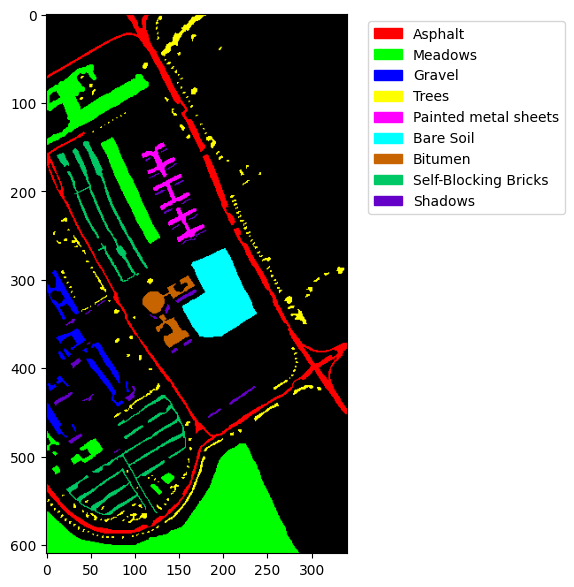

In [69]:
import matplotlib.patches as mpatches
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
normalized_colors = np.array(spectral.spy_colors) / 255.0

labels = ['Asphalt', 'Meadows',  'Gravel','Trees', 'Painted metal sheets', 'Bare Soil','Bitumen', 'Self-Blocking Bricks', 'Shadows', ]
patches = [mpatches.Patch(color=c, label=label) for c, label in zip(normalized_colors[1:], labels)]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

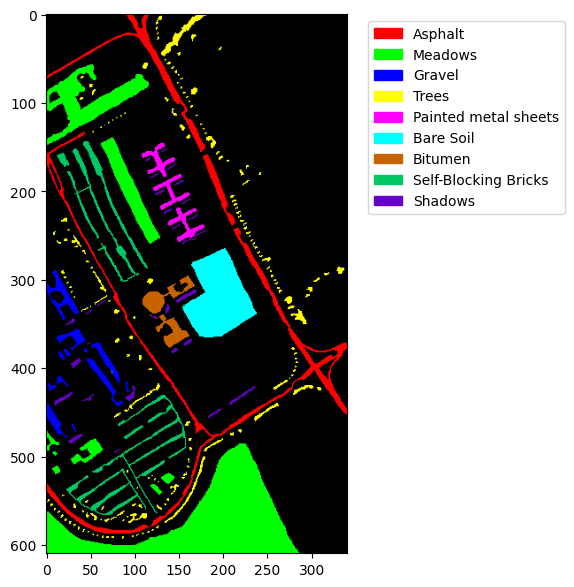

In [70]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
labels = ['Asphalt', 'Meadows',  'Gravel','Trees', 'Painted metal sheets', 'Bare Soil','Bitumen', 'Self-Blocking Bricks', 'Shadows', ]
patches = [mpatches.Patch(color=c, label=label) for c, label in zip(normalized_colors[1:], labels)]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [71]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)

# Grad-CAM

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

In [ ]:
X, y = loadData(dataset)
X.shape

(610, 340, 103)

In [ ]:
X,pca = applyPCA(X, numComponents=15) 
X.shape

(610, 340, 15)

In [ ]:
import numpy as np
from tf_keras_vis.gradcam import Gradcam
from matplotlib import pyplot as plt
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import keras

PATCH_SIZE = 25
STRIDE = 5  
height, width = 610, 340

gradcam_outputs = np.zeros((height, width))
overlap_count = np.zeros((height, width))
labels = ['Asphalt', 'Meadows',  'Gravel','Trees', 'Painted metal sheets', 'Bare Soil','Bitumen', 'Self-Blocking Bricks', 'Shadows', ]

model = keras.models.load_model("best-model.keras")
last_conv_layer_name = 'conv2d'

replace2linear = ReplaceToLinear()
gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
for k, label in enumerate(labels):
    if k <= 3:
        continue
    score = CategoricalScore(k)

    for i in range(0, height - PATCH_SIZE + 1, STRIDE):
        for j in range(0, width - PATCH_SIZE + 1, STRIDE):
            patch = X[i:i+PATCH_SIZE, j:j+PATCH_SIZE, :]
            img_array = patch.reshape(1, PATCH_SIZE, PATCH_SIZE, 15, 1).astype('float32')
            
            cam = gradcam(score, img_array, penultimate_layer=last_conv_layer_name)
            
            gradcam_outputs[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += cam[0]
            overlap_count[i:i+PATCH_SIZE, j:j+PATCH_SIZE] += 1


    gradcam_outputs = np.divide(gradcam_outputs, overlap_count, where=overlap_count!=0) 

    plt.figure(figsize=(10, 10))
    plt.imshow(gradcam_outputs, cmap='jet')
    plt.colorbar()
    plt.title(f'Grad-CAM Visualization {k} - {label}')
    plt.show()
    plt.imsave(f"GradCAM outputs\{k}_{label}_gradcam_outputs.jpg", gradcam_outputs, cmap='jet')

In [ ]:
from joblib import dump, load
import numpy as np
import os


def createImageCubes_disk(X, y, num_classes, windowSize=5, removeZeroLabels=True, output_dir="temp_data"):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    
    os.makedirs(output_dir, exist_ok=True)
    
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            label = y[r - margin, c - margin]

            if removeZeroLabels and label == 0:
                continue
            label = keras.utils.to_categorical(label-1, num_classes=num_classes)
            dump(patch, os.path.join(output_dir, f"patch_{patchIndex}.joblib"))
            dump(label, os.path.join(output_dir, f"label_{patchIndex}.joblib"))
            patchIndex += 1
    
    print(f"Saved {patchIndex} patches to disk in {output_dir}")
    return patchIndex  

def loadPatchFromDisk(output_dir, patchIndex):
    patch = load(os.path.join(output_dir, f"patch_{patchIndex}.joblib"))
    label = load(os.path.join(output_dir, f"label_{patchIndex}.joblib"))
    return patch, label

In [33]:
X, y = loadData(dataset)

output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16
patchIndex = createImageCubes_disk(X, y,num_classes=output_units, windowSize=windowSize)

Saved 42776 patches to disk in temp_data


In [ ]:
patchIndex = 42776

In [23]:
X, y = loadPatchFromDisk("temp_data", 0) 

X.shape, y.shape  

((25, 25, 103), (9,))

In [22]:
import numpy as np
from joblib import load
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:


def class_band_importance_disk(model, pca, class_idx, data_dir, num_patches, num_bands=103, num_classes=9):
    importance_scores = np.zeros(num_bands)
    class_count = 0
  
    class_patch_indices = []
    for i in range(num_patches):
        _, label = loadPatchFromDisk(data_dir, i)
        if np.argmax(label) == class_idx:
            class_patch_indices.append(i)

    # Only 100 patches for each class due to time constraints
    for i in tqdm(class_patch_indices[:100], desc=f"Class {class_idx}"):
        patch, _ = loadPatchFromDisk(data_dir, i)

        original_pca = pca.transform(patch.reshape(-1, num_bands)).reshape(1, *patch.shape[:-1], -1)
        original_prob = model.predict(original_pca)[0, class_idx]

        batch_scores = np.zeros(num_bands)
        for band in range(num_bands):
            modified_patch = patch.copy()
            modified_patch[:,:,band] = 0
            modified_pca = pca.transform(modified_patch.reshape(-1, num_bands)).reshape(1, *patch.shape[:-1], -1)
            modified_prob = model.predict(modified_pca)[0, class_idx]
            batch_scores[band] = original_prob - modified_prob
        
        importance_scores += batch_scores
        class_count += 1
    
    return importance_scores / class_count if class_count > 0 else importance_scores


wavelengths = np.linspace(430, 860, 103)
plt.figure(figsize=(15,7))
labels = ['Asphalt', 'Meadows',  'Gravel','Trees', 'Painted metal sheets', 'Bare Soil','Bitumen', 'Self-Blocking Bricks', 'Shadows', ]

output_dir = "band_importance_scores"
os.makedirs(output_dir, exist_ok=True)
for class_idx in range(output_units):  
    scores = class_band_importance_disk(model, pca, class_idx, "temp_data", patchIndex, num_classes=output_units)
    sensitiviy_plot = plt.plot(wavelengths, scores, label=labels[class_idx])
    file_path = os.path.join(output_dir, f"class_{class_idx}_importance_scores.npy")
    np.save(file_path, scores)
    print(f"Saved importance scores for class {class_idx} to {file_path}")
    plt.savefig(f"Save outputs\\{class_idx}_class.jpg", bbox_inches='tight')
    plt.clf()  

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Importance Score')
plt.title('Band Importance per Class (Pavia University)')
plt.tight_layout()
plt.show()


In [18]:
from joblib import dump, load

dump(pca, "pca_model.joblib")
pca = load("pca_model.joblib")

In [ ]:
def class_specific_misclassified_band_analysis(model, pca, data_dir, num_patches, num_classes=9, save_dir="misclass_analysis", wavelengths=None):

    os.makedirs(save_dir, exist_ok=True)
    class_error_scores = np.zeros((num_classes, 103))  # 103 bands for PaviaU
    error_counts = np.zeros(num_classes)
    
    for i in tqdm(range(num_patches), desc="Analyzing misclassifications"):
        patch, true_label = loadPatchFromDisk(data_dir, i)
        true_class = np.argmax(true_label)
        
        pca_patch = pca.transform(patch.reshape(-1, 103)).reshape(1, *patch.shape[:-1], -1)
        pred_class = np.argmax(model.predict(pca_patch))
        
        if pred_class != true_class:
            original_prob = model.predict(pca_patch)[0, true_class]
            for band in range(103):
                modified = patch.copy()
                modified[:,:,band] = 0
                modified_pca = pca.transform(modified.reshape(-1, 103)).reshape(1, *patch.shape[:-1], -1)
                modified_prob = model.predict(modified_pca)[0, true_class]
                class_error_scores[true_class, band] += (original_prob - modified_prob)
            error_counts[true_class] += 1
    
    for class_idx in range(num_classes):
        if error_counts[class_idx] > 0:
            class_error_scores[class_idx] /= error_counts[class_idx]

    np.save(os.path.join(save_dir, "class_error_scores.npy"), class_error_scores)
    np.save(os.path.join(save_dir, "error_counts.npy"), error_counts)

    for class_idx in range(num_classes):
        if error_counts[class_idx] == 0:
            continue
            
        plt.figure(figsize=(12, 5))
        if wavelengths is not None:
            plt.plot(wavelengths, class_error_scores[class_idx])
            plt.xlabel('Wavelength (nm)')
        else:
            plt.plot(range(103), class_error_scores[class_idx])
            plt.xlabel('Band Index')
            
        plt.ylabel('Average Error Contribution')
        plt.title(f'Bands Contributing to Misclassifications of Class {class_idx}')
        plt.grid(True)

        plt.savefig(os.path.join(save_dir, f'misclass_band_importance_class_{class_idx}.png'), 
                   bbox_inches='tight', dpi=300)
        plt.close()
    
    return class_error_scores, error_counts

wavelengths = np.linspace(430, 860, 103)  # PU wavelengths
class_error_scores, error_counts = class_specific_misclassified_band_analysis(
    model, pca, "temp_data", patchIndex, num_classes=9,
    save_dir="misclass_results", wavelengths=wavelengths
)

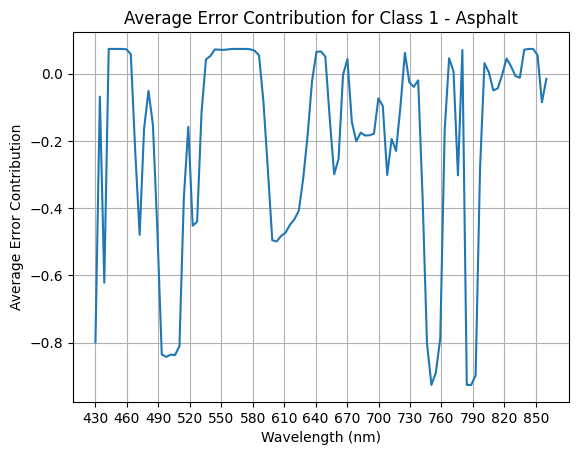

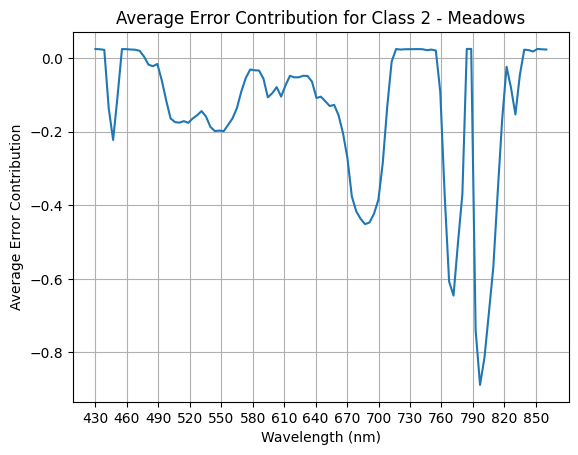

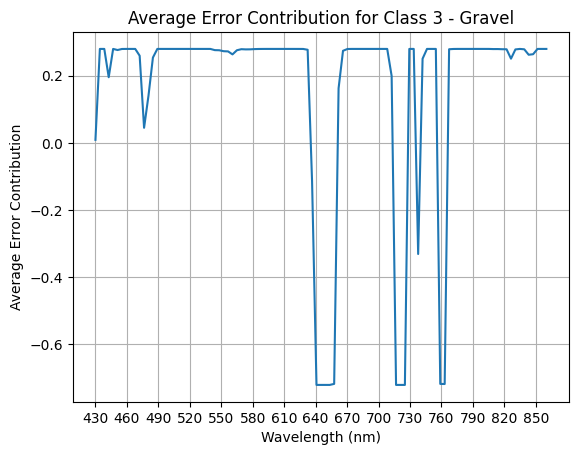

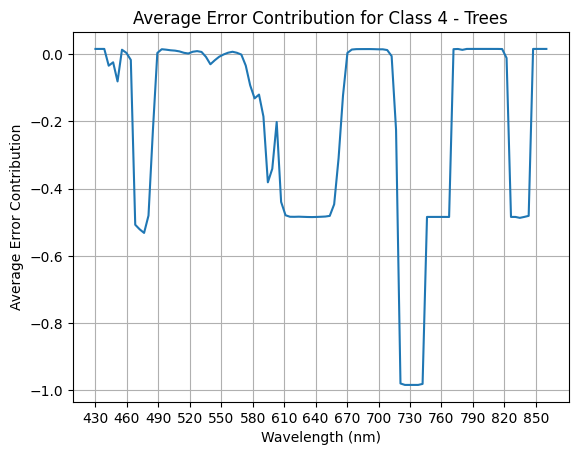

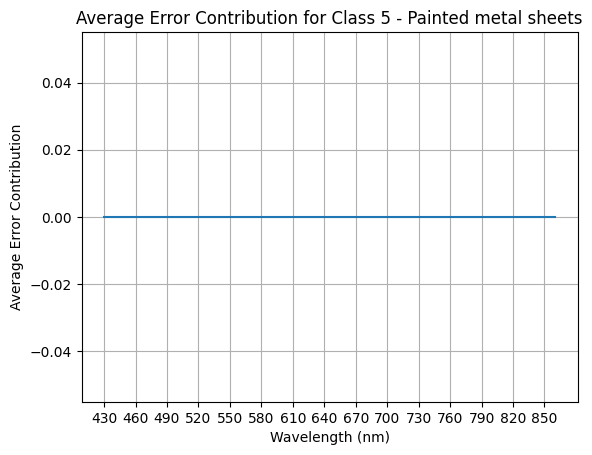

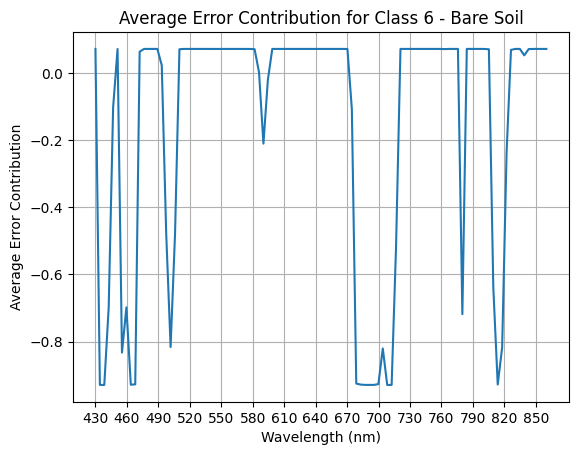

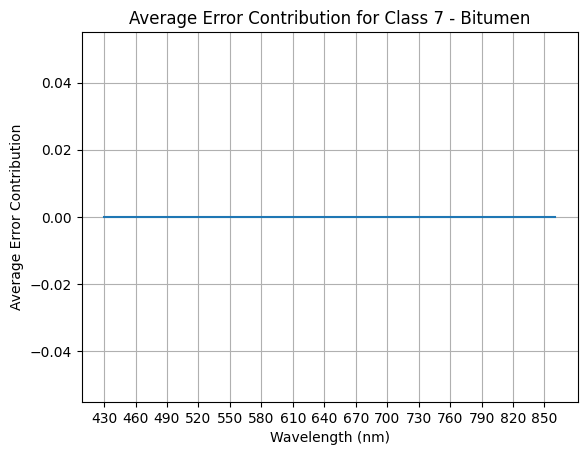

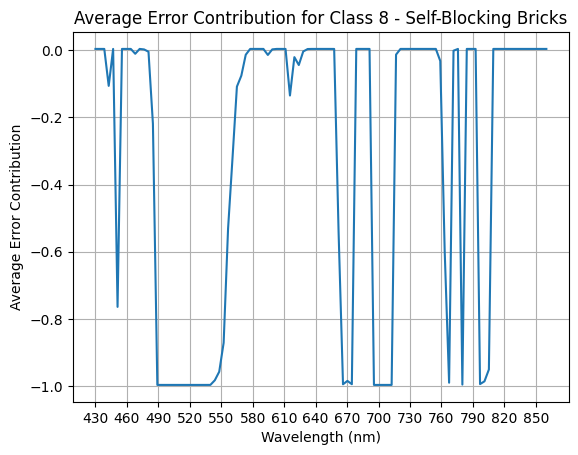

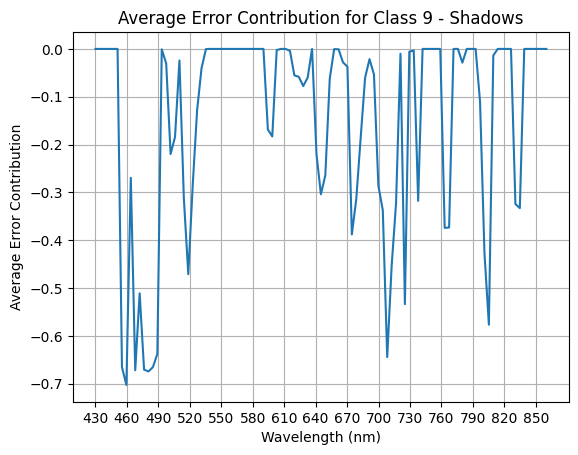

In [20]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Asphalt', 'Meadows',  'Gravel','Trees', 'Painted metal sheets', 'Bare Soil','Bitumen', 'Self-Blocking Bricks', 'Shadows', ]

wavelengths = np.linspace(430, 860, 103)  # PU wavelengths
scores = np.load("misclass_results/class_error_scores.npy")
for i in range(9):
    plt.plot(wavelengths, scores[i], label=f'Class {i}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Average Error Contribution')
    plt.title(f'Average Error Contribution for Class {i + 1} - {labels[i]}')
    plt.grid(True)
    plt.xticks(np.arange(430, 860, 30))
    plt.show()
    

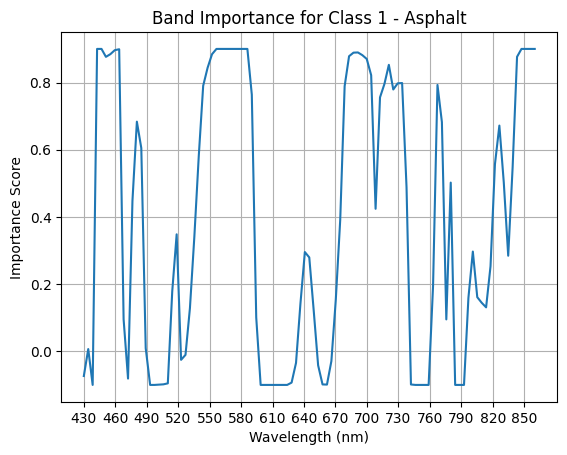

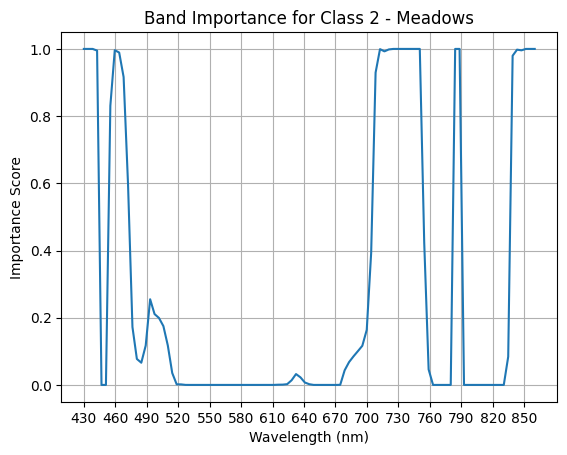

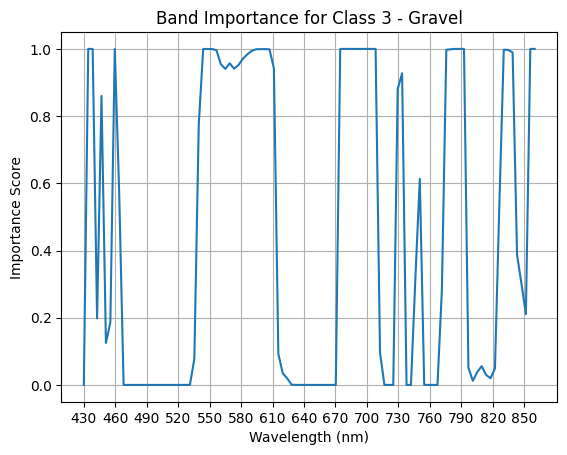

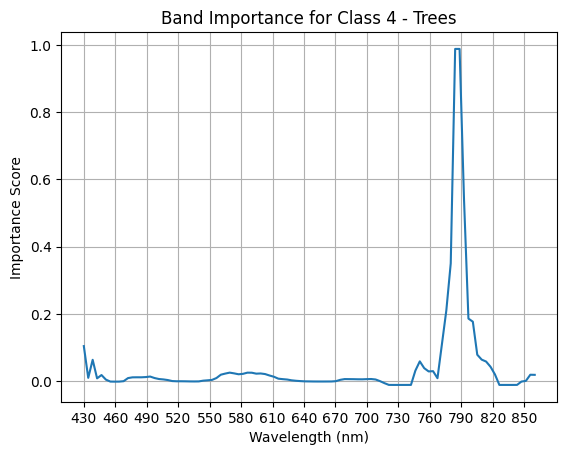

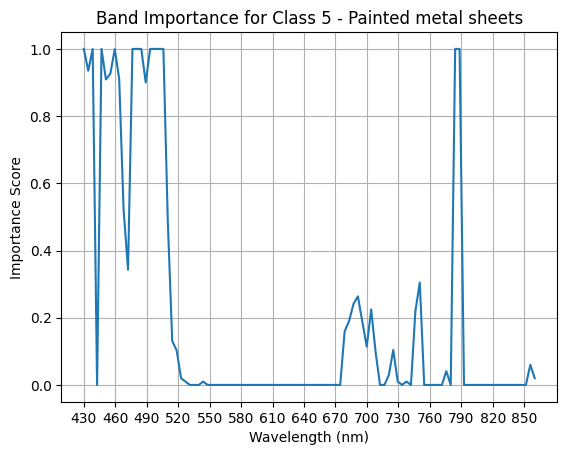

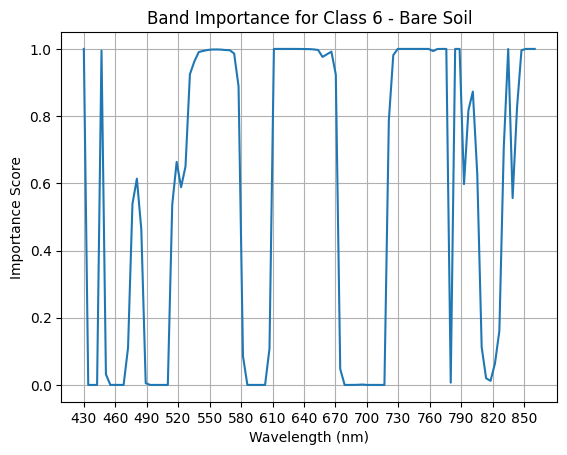

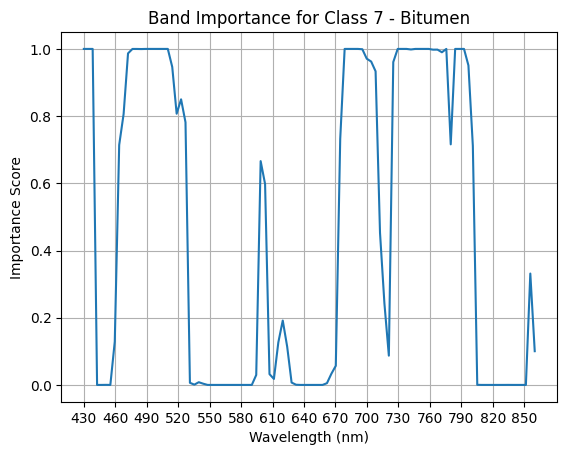

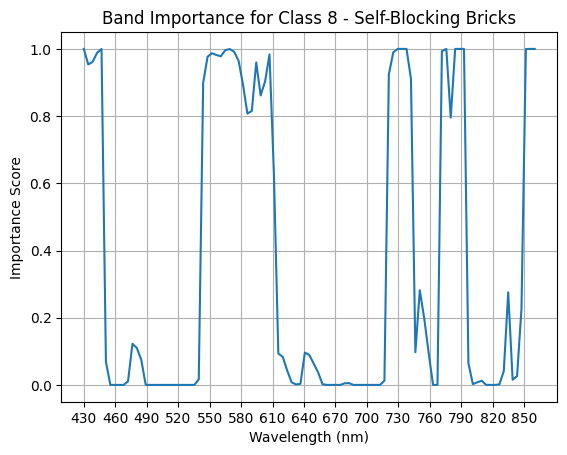

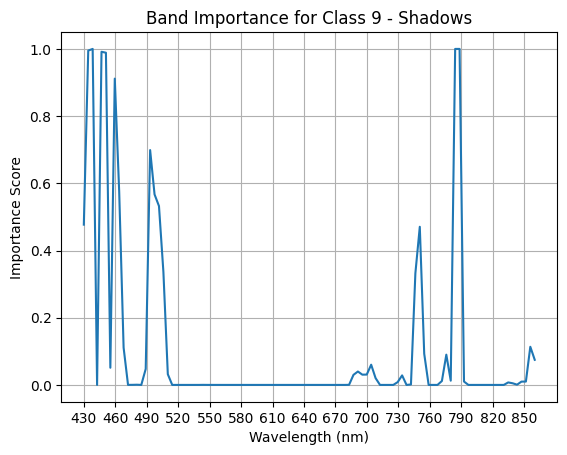

In [22]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Asphalt', 'Meadows',  'Gravel','Trees', 'Painted metal sheets', 'Bare Soil','Bitumen', 'Self-Blocking Bricks', 'Shadows', ]

wavelengths = np.linspace(430, 860, 103)  # PU wavelengths
for i in range(9):
    scores = np.load(f"band_importance_scores/class_{i}_importance_scores.npy")
    plt.plot(wavelengths, scores, label=f'Class {i}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Importance Score')
    plt.title(f'Band Importance for Class {i + 1} - {labels[i]}')
    plt.grid(True)
    plt.xticks(np.arange(430, 860, 30))
    plt.show()